In [43]:
library(ggplot2)
library(dplyr)
library(glue)
options(repr.plot.width=25, repr.plot.height=8)

In [44]:
output = read.table("/Users/shayecarver/condPCA/Gamma-Pois_Simulation/output.txt",header=TRUE)
# get distinct entries
output = output %>% distinct()
# rename flag to 7 cts
output[is.na(output$flag),]$flag = "7_cts"
# simulations:
# 1: 7 cts (20k cells), state within one ct
# 2: 7 cts (20k cells), state across all cts
# 3: 100 cts (40k cells), state within one ct
# 4: 100 cts (40k cells), state across all cts

# extract cts and state types that you need to iterate over
state_type = unique(output$state_type)
cts = unique(output$flag)

# remove any rows with NA values
output <- na.omit(output)

# # Combine col1 and col2 into a new column named combined_col
# output$perc_genes_cells <- paste(output$perc_genes, output$perc_cells, sep = ", ")
# # factor this column
# output$perc_genes_cells <- factor(output$perc_genes_cells, levels = unique(output$perc_genes_cells))

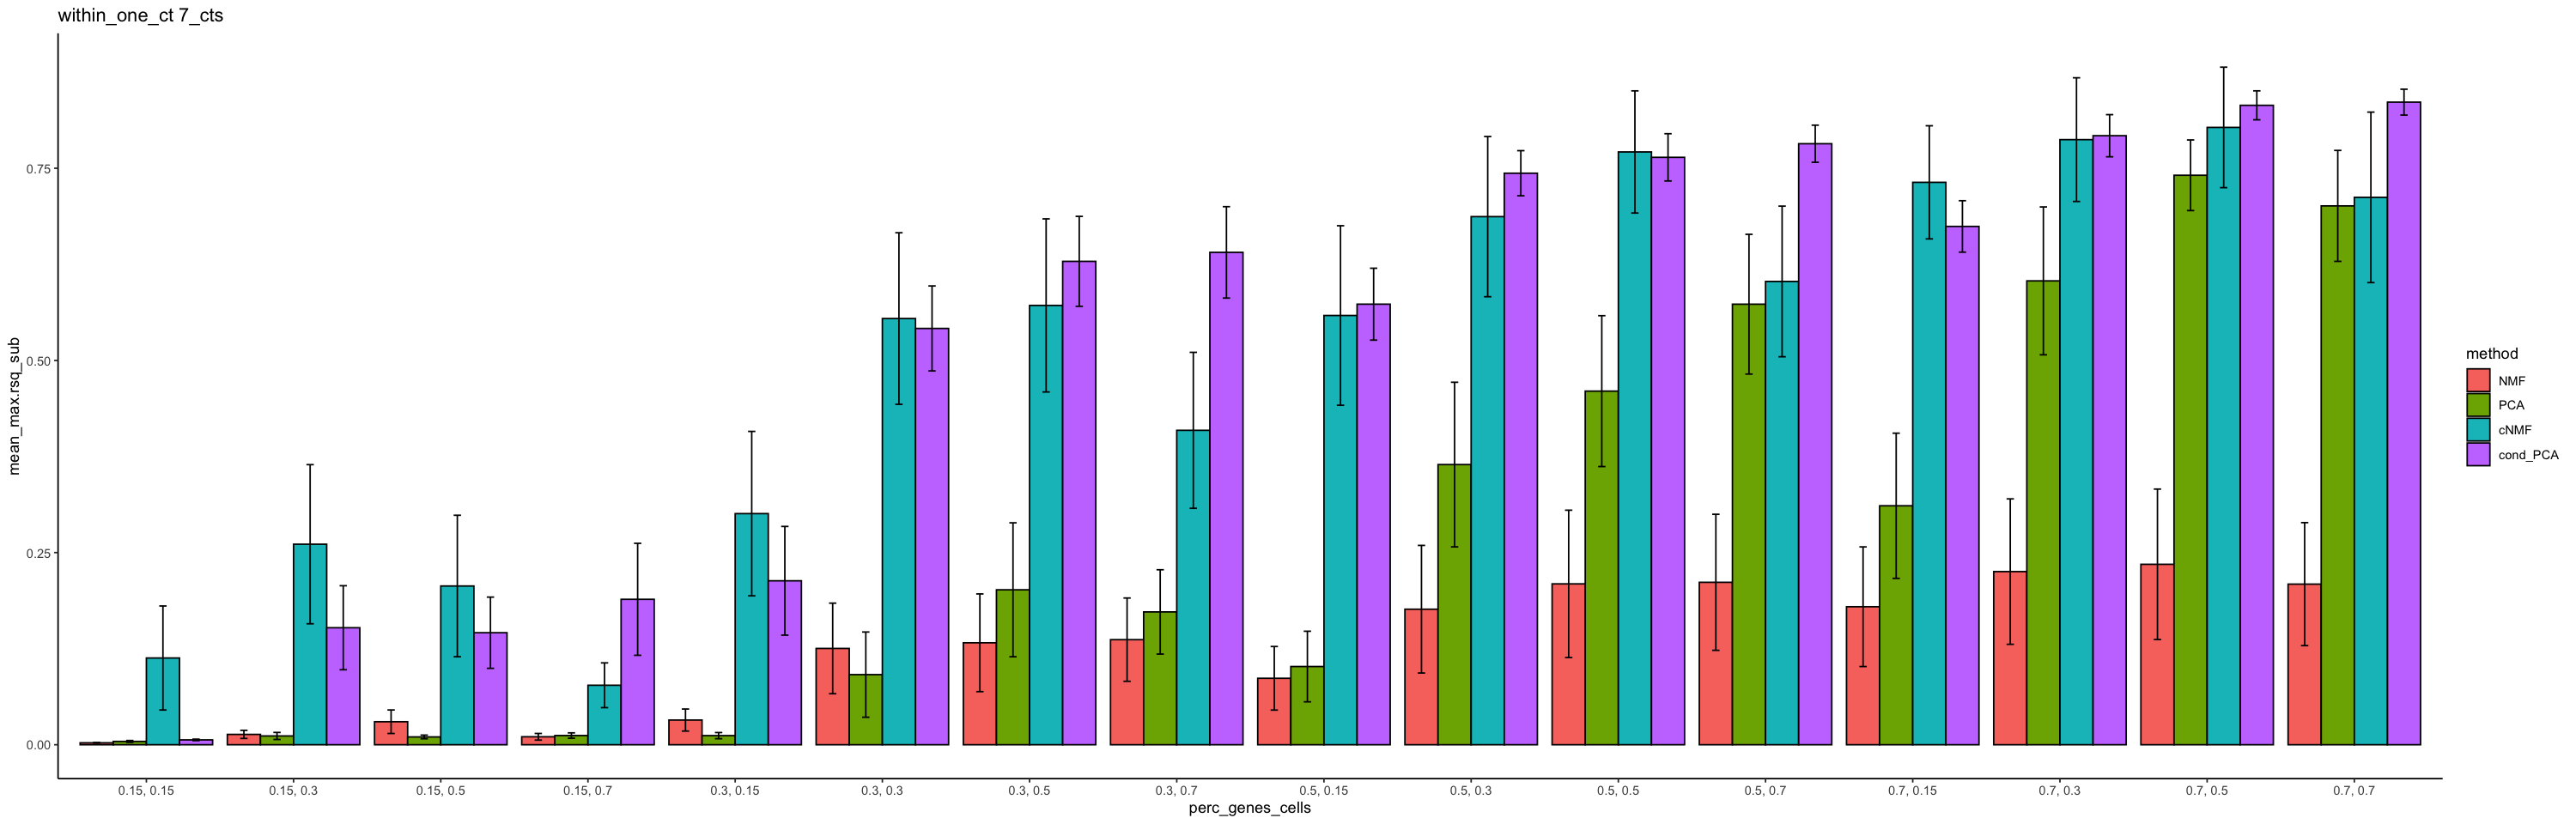

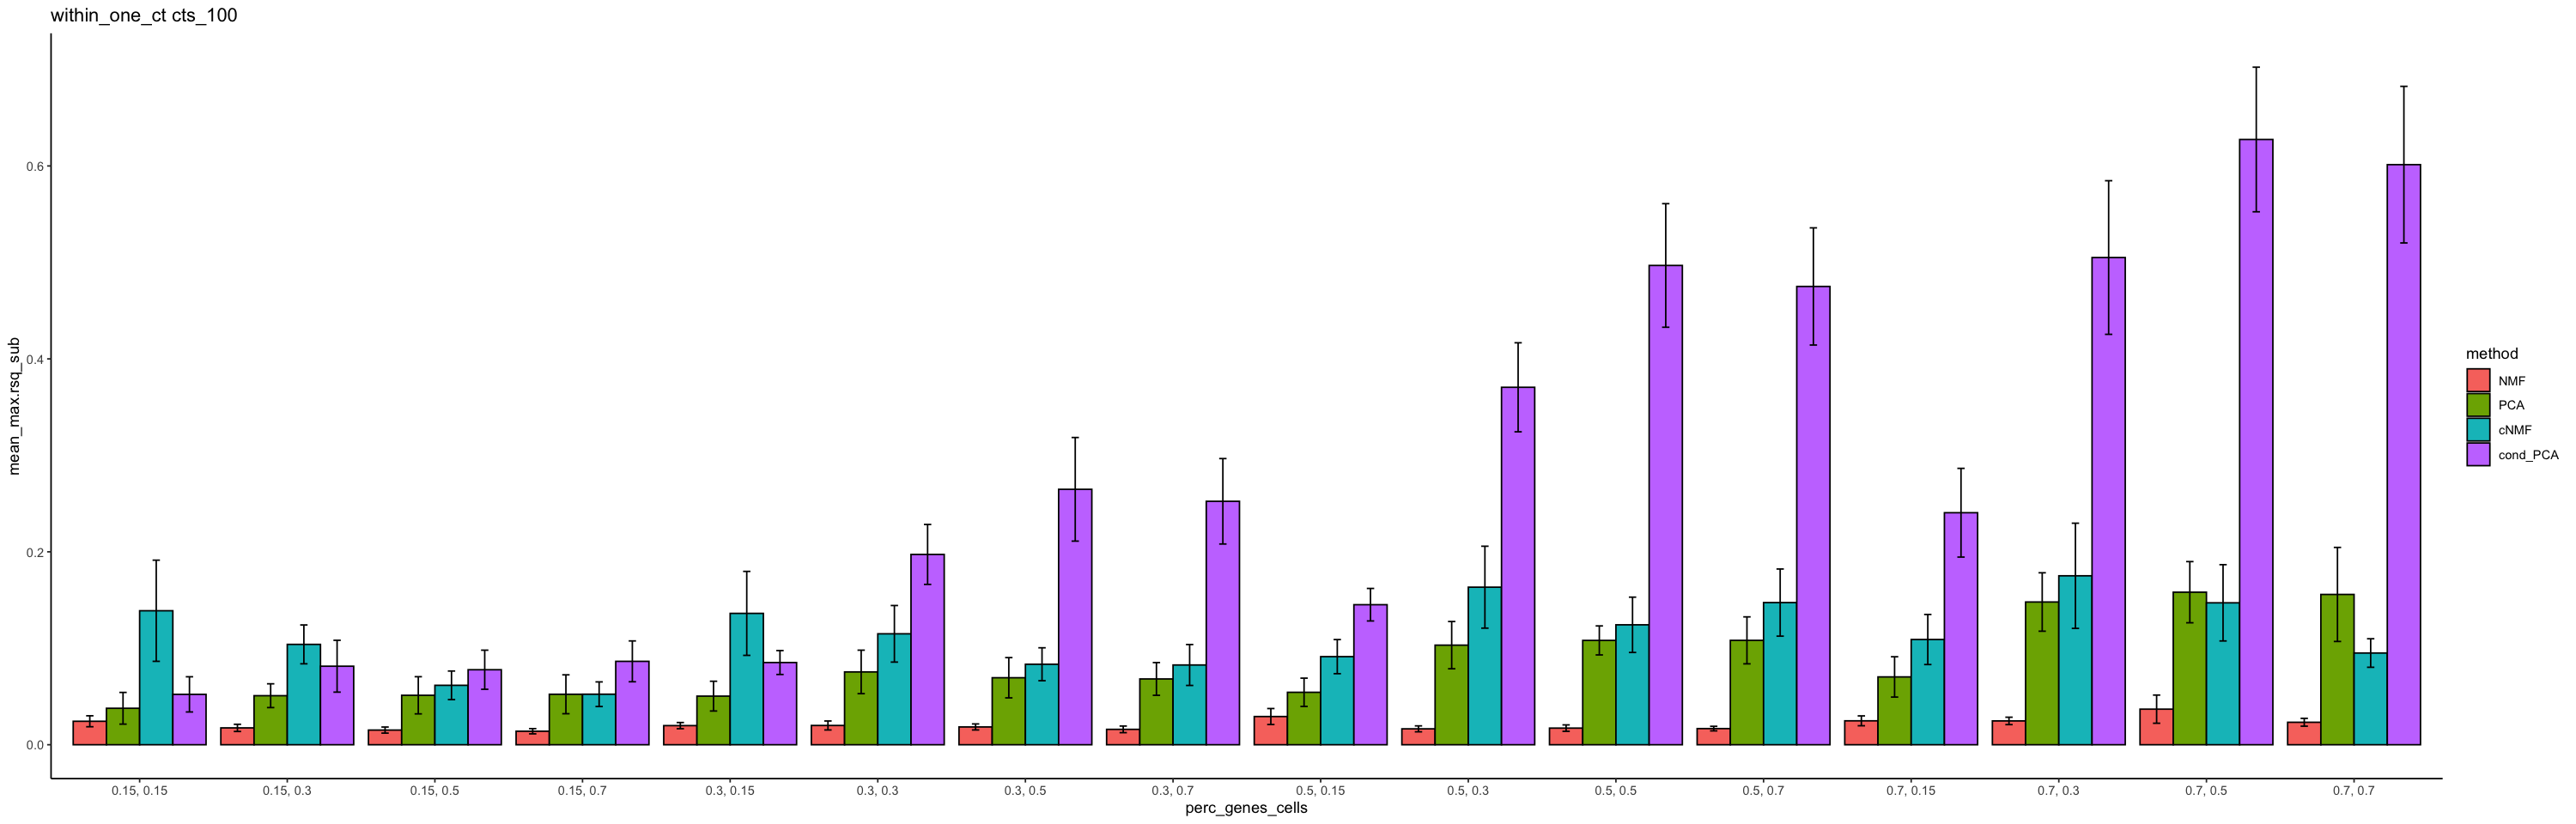

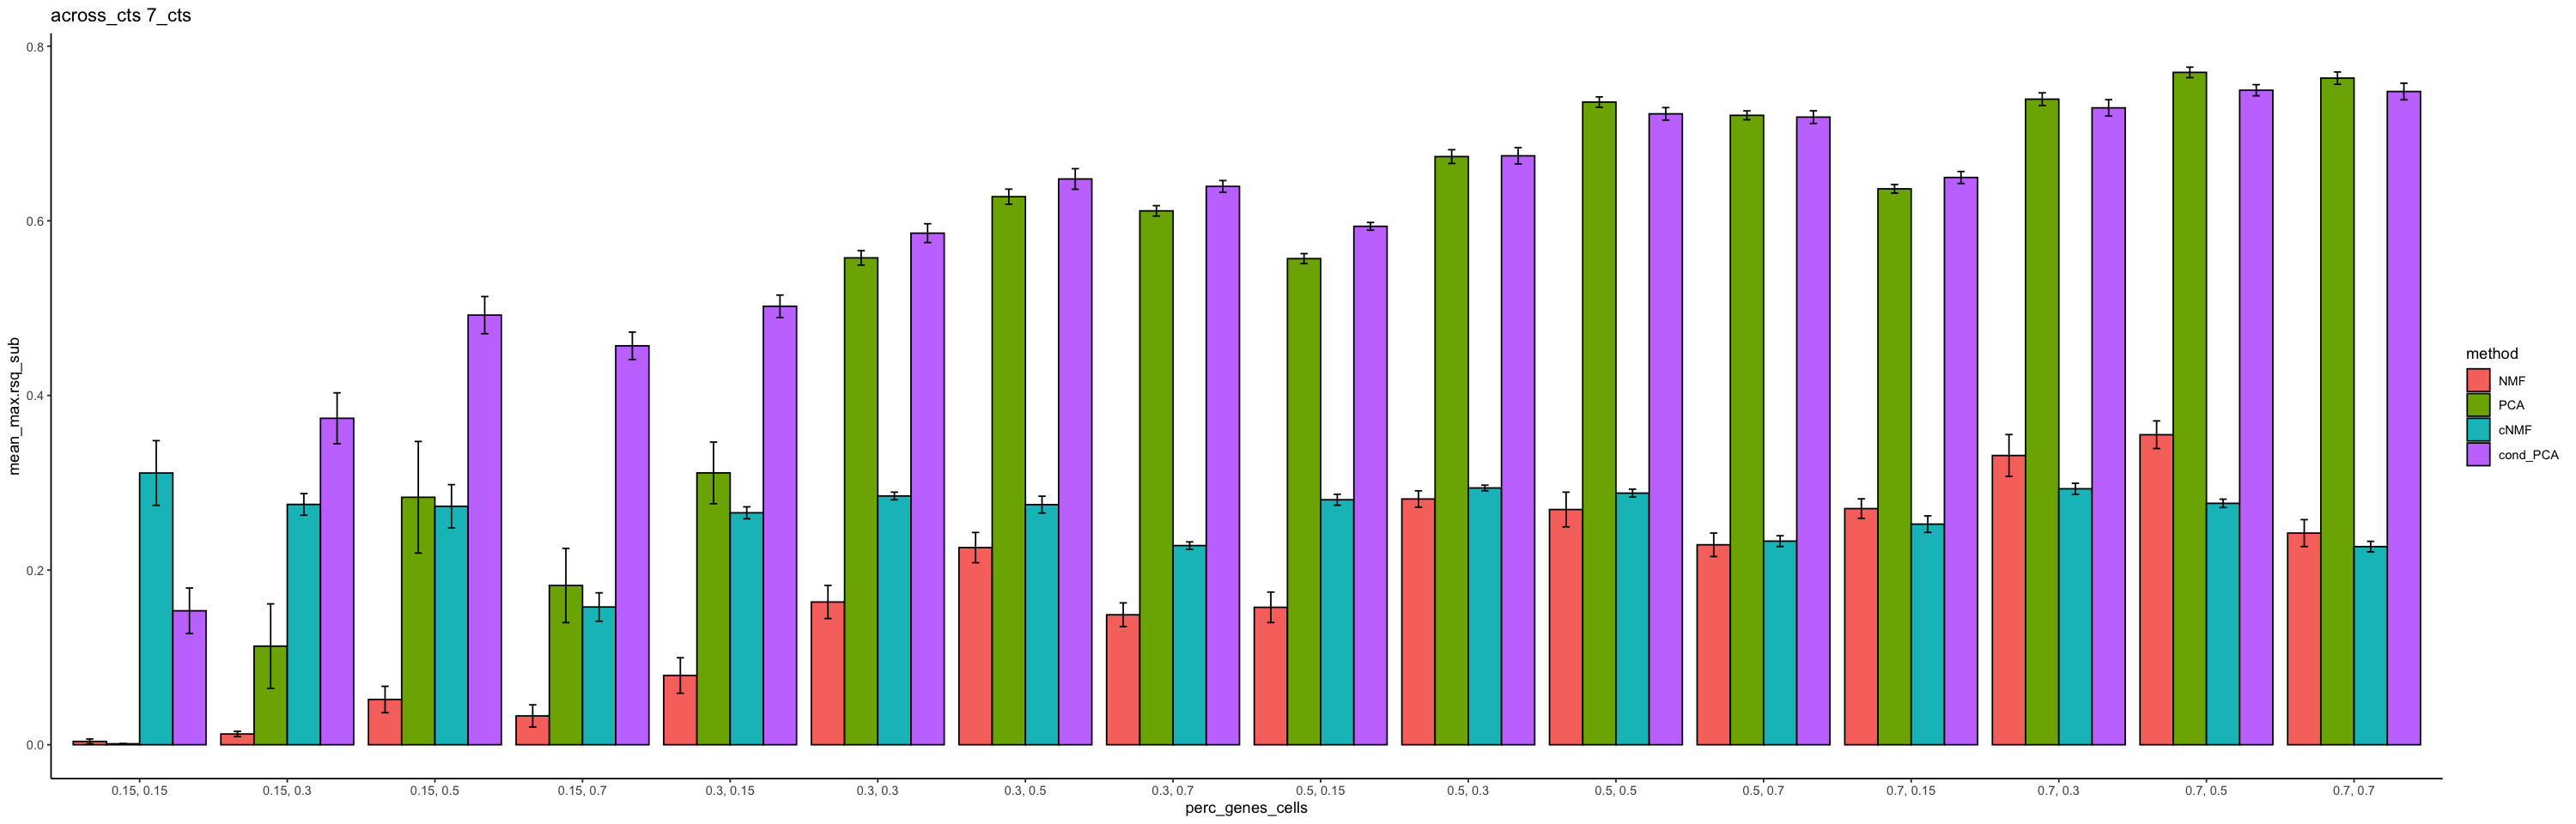

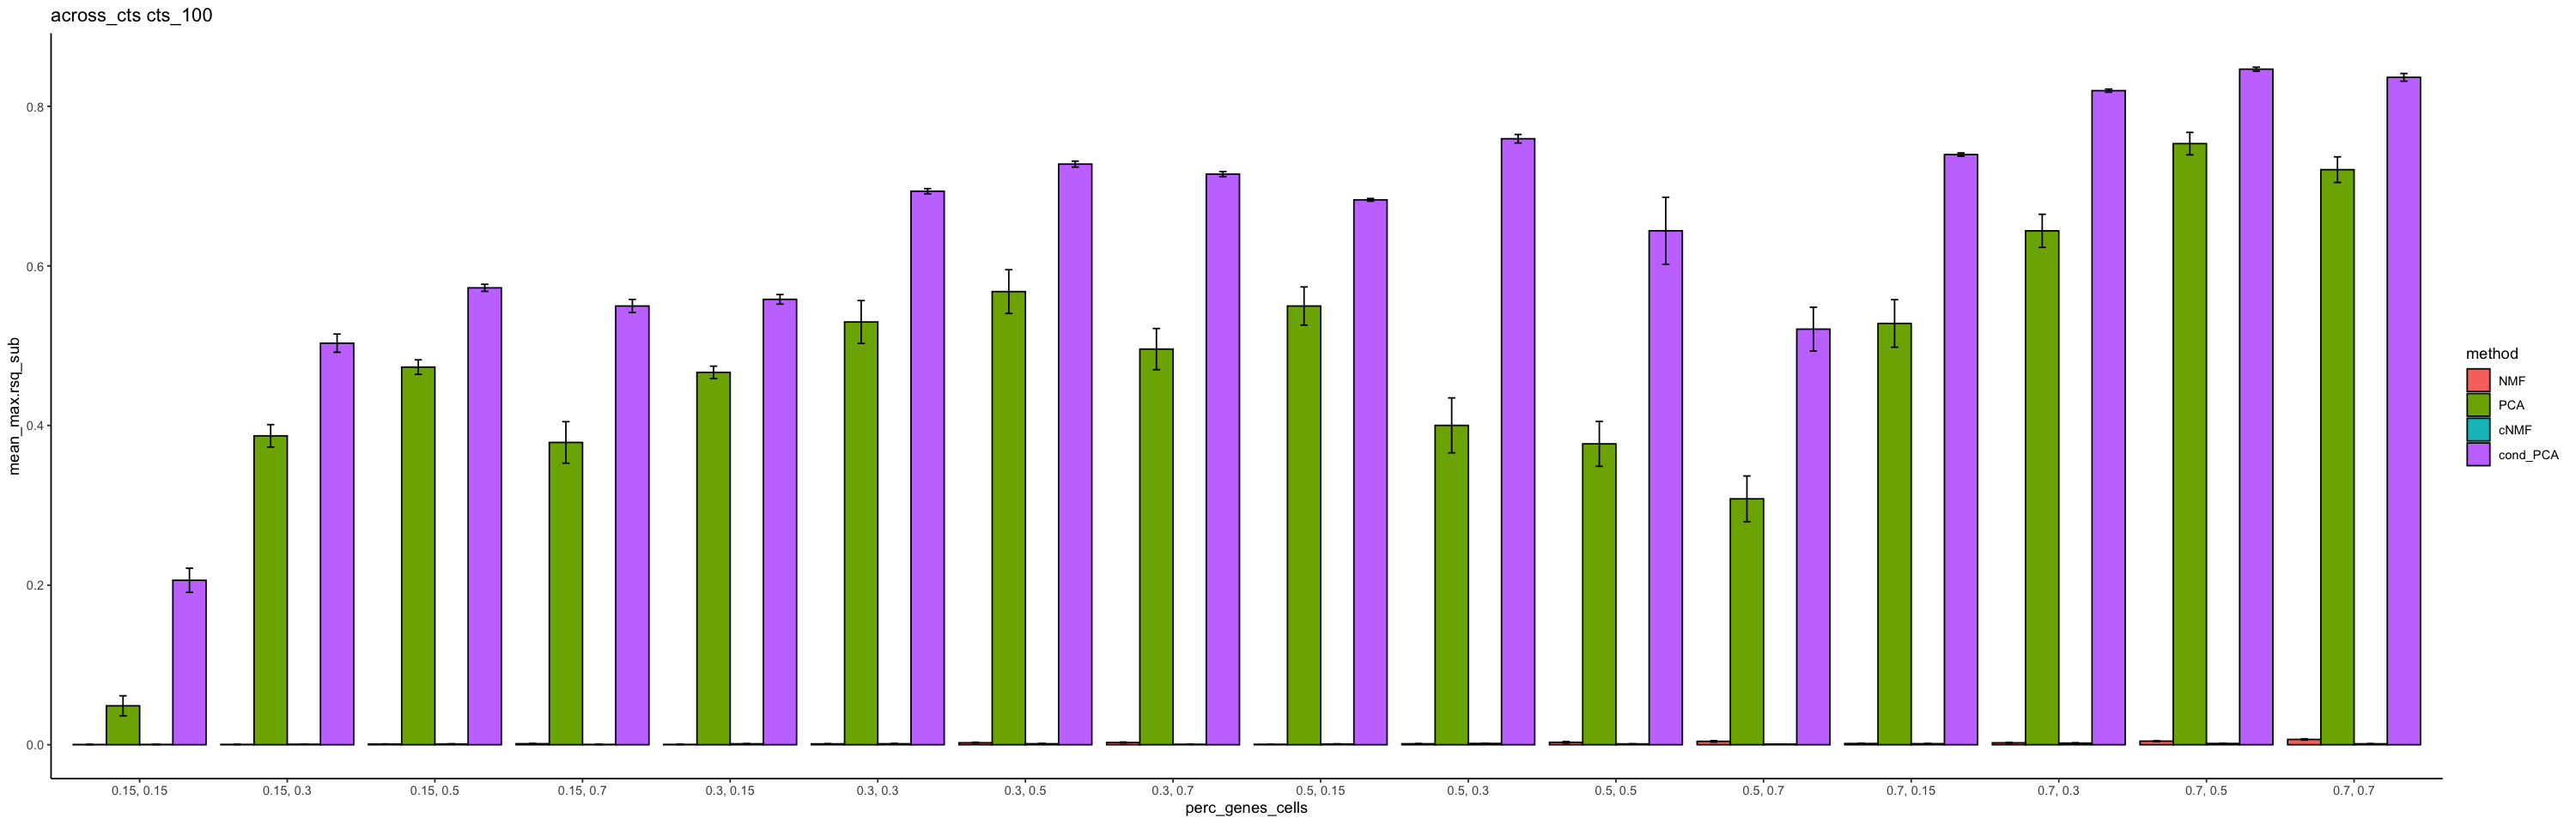

In [47]:
# create a copy of the dataframe so that dplyr doesn't produce errors in groupby
tmp = output 

# compute statistic of interest across random seeds of a given simulation
compute_summary <- function(data, statistic, identifier) {
  summary_result <- data %>% group_by(method,state_type,dim, total_cells, flag, perc_genes, perc_cells) %>% 
                      summarise(across(c(adj.rsq,max.rsq,max.rsq_sub),statistic), .groups = 'drop') %>%
    ungroup() %>%
    as.data.frame()

    

  # Append identifier to last three columns
  last_three <- tail(colnames(summary_result), 3)
  new_col_names <- paste0(identifier, last_three)
  colnames(summary_result)[(ncol(summary_result) - 2):ncol(summary_result)] <- new_col_names
  
  return(summary_result)
}

# Compute means
means <- compute_summary(tmp, mean, "mean_")

# Compute standard errors
se <- compute_summary(tmp, ~sd(.)/sqrt(length(.)), "se_")

# Compute confidence intervals
conf <- compute_summary(tmp, ~sd(.)/sqrt(length(.))*qnorm(0.975), "conf_")

# Merge mean, se, and conf interval dataframes
merged <- means %>%
  inner_join(se, by = colnames(means)[1:7]) %>%
  inner_join(conf, by = colnames(means)[1:7])


# add column combining percent cells and percent genes
merged$perc_genes_cells = paste(merged$perc_genes, merged$perc_cells, sep=", ")

# Plot relevant metric

# iterate over states across cell types and within one cell type
for (state in state_type){
    # iterate over simulating 7 or 100 cell types
    for (num_cts in cts){
        # subset the data
        sub_merged = merged[(merged$state_type == state & merged$flag == num_cts),]

        p1 = ggplot(sub_merged, aes(x = perc_genes_cells, y = mean_max.rsq_sub, fill=method))+
                geom_bar(stat="identity", color="black", position=position_dodge()) + ggtitle(glue("{state} {num_cts} {variable}"))+
                geom_errorbar(aes(ymin=mean_max.rsq_sub-se_max.rsq_sub, ymax=mean_max.rsq_sub+se_max.rsq_sub), width=.2,
                position=position_dodge(.9)) + ggtitle(glue("{state} {num_cts}")) + theme_classic()
        print(p1)
        
        
    }
    
}

# Plot all three metrics
# for (state in state_type){
#     for (num_cts in cts){
#         for (variable in colnames(merged)[grep("mean", colnames(merged))]){
#             sub_merged = merged[(merged$state_type == state & merged$flag == num_cts),]
#             print(variable)
#             print(state)
#             print(num_cts)
#             p1 = ggplot(sub_merged, aes(x = perc_genes_cells, y = .data[[rlang::sym(variable)]], fill=method))+
#                     geom_bar(stat="identity", color="black", position=position_dodge()) + ggtitle(glue("{state} {num_cts} {variable}"))
#             print(p1)
#         }
#     }
# }
